# Reconhecimento facial e classificação de objetos

> Atenção: este notebook deve ser executado com ambiente do tipo GPO para uma melhor performance.

## 1. Requerimentos

### 1.1 Bibliotecas

Todas as bibliotecas já estão instaladas no Google Colab.

* OpenCV >=3.4.3
* Numpy >=1.18.1
* Keras >= 2.3.1
* Tensorflow >= 2.2.0

### 1.2 Arquivos

Baixe o repositório do GitHub utilizando o comando abaixo. Em caso de atualização, utilize o comando para apagar o diretório antes.

In [ ]:
!rm -rf fiap-ml-visao-computacional/

In [ ]:
!git clone https://github.com/michelpf/fiap-ml-visao-computacional

Cloning into 'fiap-ml-visao-computacional'...
remote: Enumerating objects: 11646, done.
remote: Counting objects: 100% (214/214), done.
remote: Compressing objects: 100% (169/169), done.
remote: Total 11646 (delta 88), reused 144 (delta 40), pack-reused 11432
Receiving objects: 100% (11646/11646), 1.03 GiB | 14.06 MiB/s, done.
Resolving deltas: 100% (539/539), done.
Checking out files: 100% (572/572), done.


Vamos agora posicionar o diretório do repositório para a aula respectiva. Nesse caso envie o comando de mudança de diretório.

In [ ]:
%cd fiap-ml-visao-computacional/aula-5-machine-learning-aplicado/

/content/fiap-ml-visao-computacional/aula-5-machine-learning-aplicado


Importação das bibliotecas.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

import datetime

from os import listdir
from os.path import isfile, join, isdir, sep

from tqdm import tqdm

# Scikit learn
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

# Tensorflow
from tensorflow.keras.models import Sequential, load_model, model_from_json
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Activation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, VGG19
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras import Model, layers
from tensorflow.keras import optimizers

# Yolo
from utils import *
from darknet import Darknet

plt.style.use('seaborn')
sns.set_style("whitegrid", {'axes.grid' : False})

## 2. Classificação de Faces

Vamos fazer um estudo de benchmarking entre os 3 classificadores: Eingenfaces, Fihserfaces e LBPH.
Para entender melhor os pontos positivos de cada um deles, foi utilizado o [dataset do LFW (Label Faces Wild)](http://vis-www.cs.umass.edu/lfw/#deepfunnel-anchor) de faces alinhadas. Diferentemente do dataset original, foi separado 19 celebridades das quais possuem, no mínimo, 40 imagens para treinamento.

In [ ]:
!git clone https://github.com/michelpf/dataset-lfw-filtered

Cloning into 'dataset-lfw-filtered'...
remote: Enumerating objects: 1897, done.
remote: Counting objects: 100% (1897/1897), done.
remote: Compressing objects: 100% (1895/1895), done.
remote: Total 1897 (delta 2), reused 1887 (delta 0), pack-reused 0
Receiving objects: 100% (1897/1897), 15.19 MiB | 24.88 MiB/s, done.
Resolving deltas: 100% (2/2), done.


Exemplos das celebridades disponíveis.

In [ ]:
# Exibição das imagens
img1 = cv2.imread("dataset-lfw-filtered/Ariel_Sharon/Ariel_Sharon_0001.jpg")
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2 = cv2.imread("dataset-lfw-filtered/Arnold_Schwarzenegger/Arnold_Schwarzenegger_0001.jpg")
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
img3 = cv2.imread("dataset-lfw-filtered/Colin_Powell/Colin_Powell_0001.jpg")
img3 = cv2.cvtColor(img3, cv2.COLOR_BGR2RGB)
img4 = cv2.imread("dataset-lfw-filtered/Donald_Rumsfeld/Donald_Rumsfeld_0001.jpg")
img4 = cv2.cvtColor(img4, cv2.COLOR_BGR2RGB)
img5 = cv2.imread("dataset-lfw-filtered/George_W_Bush/George_W_Bush_0001.jpg")
img5 = cv2.cvtColor(img5, cv2.COLOR_BGR2RGB)
img6 = cv2.imread("dataset-lfw-filtered/Gerhard_Schroeder/Gerhard_Schroeder_0001.jpg")
img6 = cv2.cvtColor(img6, cv2.COLOR_BGR2RGB)
img7 = cv2.imread("dataset-lfw-filtered/Gloria_Macapagal_Arroyo/Gloria_Macapagal_Arroyo_0001.jpg")
img7 = cv2.cvtColor(img7, cv2.COLOR_BGR2RGB)
img8 = cv2.imread("dataset-lfw-filtered/Hugo_Chavez/Hugo_Chavez_0001.jpg")
img8 = cv2.cvtColor(img8, cv2.COLOR_BGR2RGB)
img9 = cv2.imread("dataset-lfw-filtered/Jacques_Chirac/Jacques_Chirac_0001.jpg")
img9 = cv2.cvtColor(img9, cv2.COLOR_BGR2RGB)
img10 = cv2.imread("dataset-lfw-filtered/Jean_Chretien/Jean_Chretien_0001.jpg")
img10 = cv2.cvtColor(img10, cv2.COLOR_BGR2RGB)
img11 = cv2.imread("dataset-lfw-filtered/Jennifer_Capriati/Jennifer_Capriati_0001.jpg")
img11 = cv2.cvtColor(img11, cv2.COLOR_BGR2RGB)
img12 = cv2.imread("dataset-lfw-filtered/John_Ashcroft/John_Ashcroft_0001.jpg")
img12 = cv2.cvtColor(img12, cv2.COLOR_BGR2RGB)
img13 = cv2.imread("dataset-lfw-filtered/Junichiro_Koizumi/Junichiro_Koizumi_0001.jpg")
img13 = cv2.cvtColor(img13, cv2.COLOR_BGR2RGB)
img14 = cv2.imread("dataset-lfw-filtered/Laura_Bush/Laura_Bush_0001.jpg")
img14 = cv2.cvtColor(img14, cv2.COLOR_BGR2RGB)
img15 = cv2.imread("dataset-lfw-filtered/Lleyton_Hewitt/Lleyton_Hewitt_0001.jpg")
img15 = cv2.cvtColor(img15, cv2.COLOR_BGR2RGB)
img16 = cv2.imread("dataset-lfw-filtered/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0001.jpg")
img16 = cv2.cvtColor(img16, cv2.COLOR_BGR2RGB)
img17 = cv2.imread("dataset-lfw-filtered/Serena_Williams/Serena_Williams_0001.jpg")
img17= cv2.cvtColor(img17, cv2.COLOR_BGR2RGB)
img18 = cv2.imread("dataset-lfw-filtered/Tony_Blair/Tony_Blair_0001.jpg")
img18 = cv2.cvtColor(img18, cv2.COLOR_BGR2RGB)
img19 = cv2.imread("dataset-lfw-filtered/Vladimir_Putin/Vladimir_Putin_0001.jpg")
img19 = cv2.cvtColor(img19, cv2.COLOR_BGR2RGB)

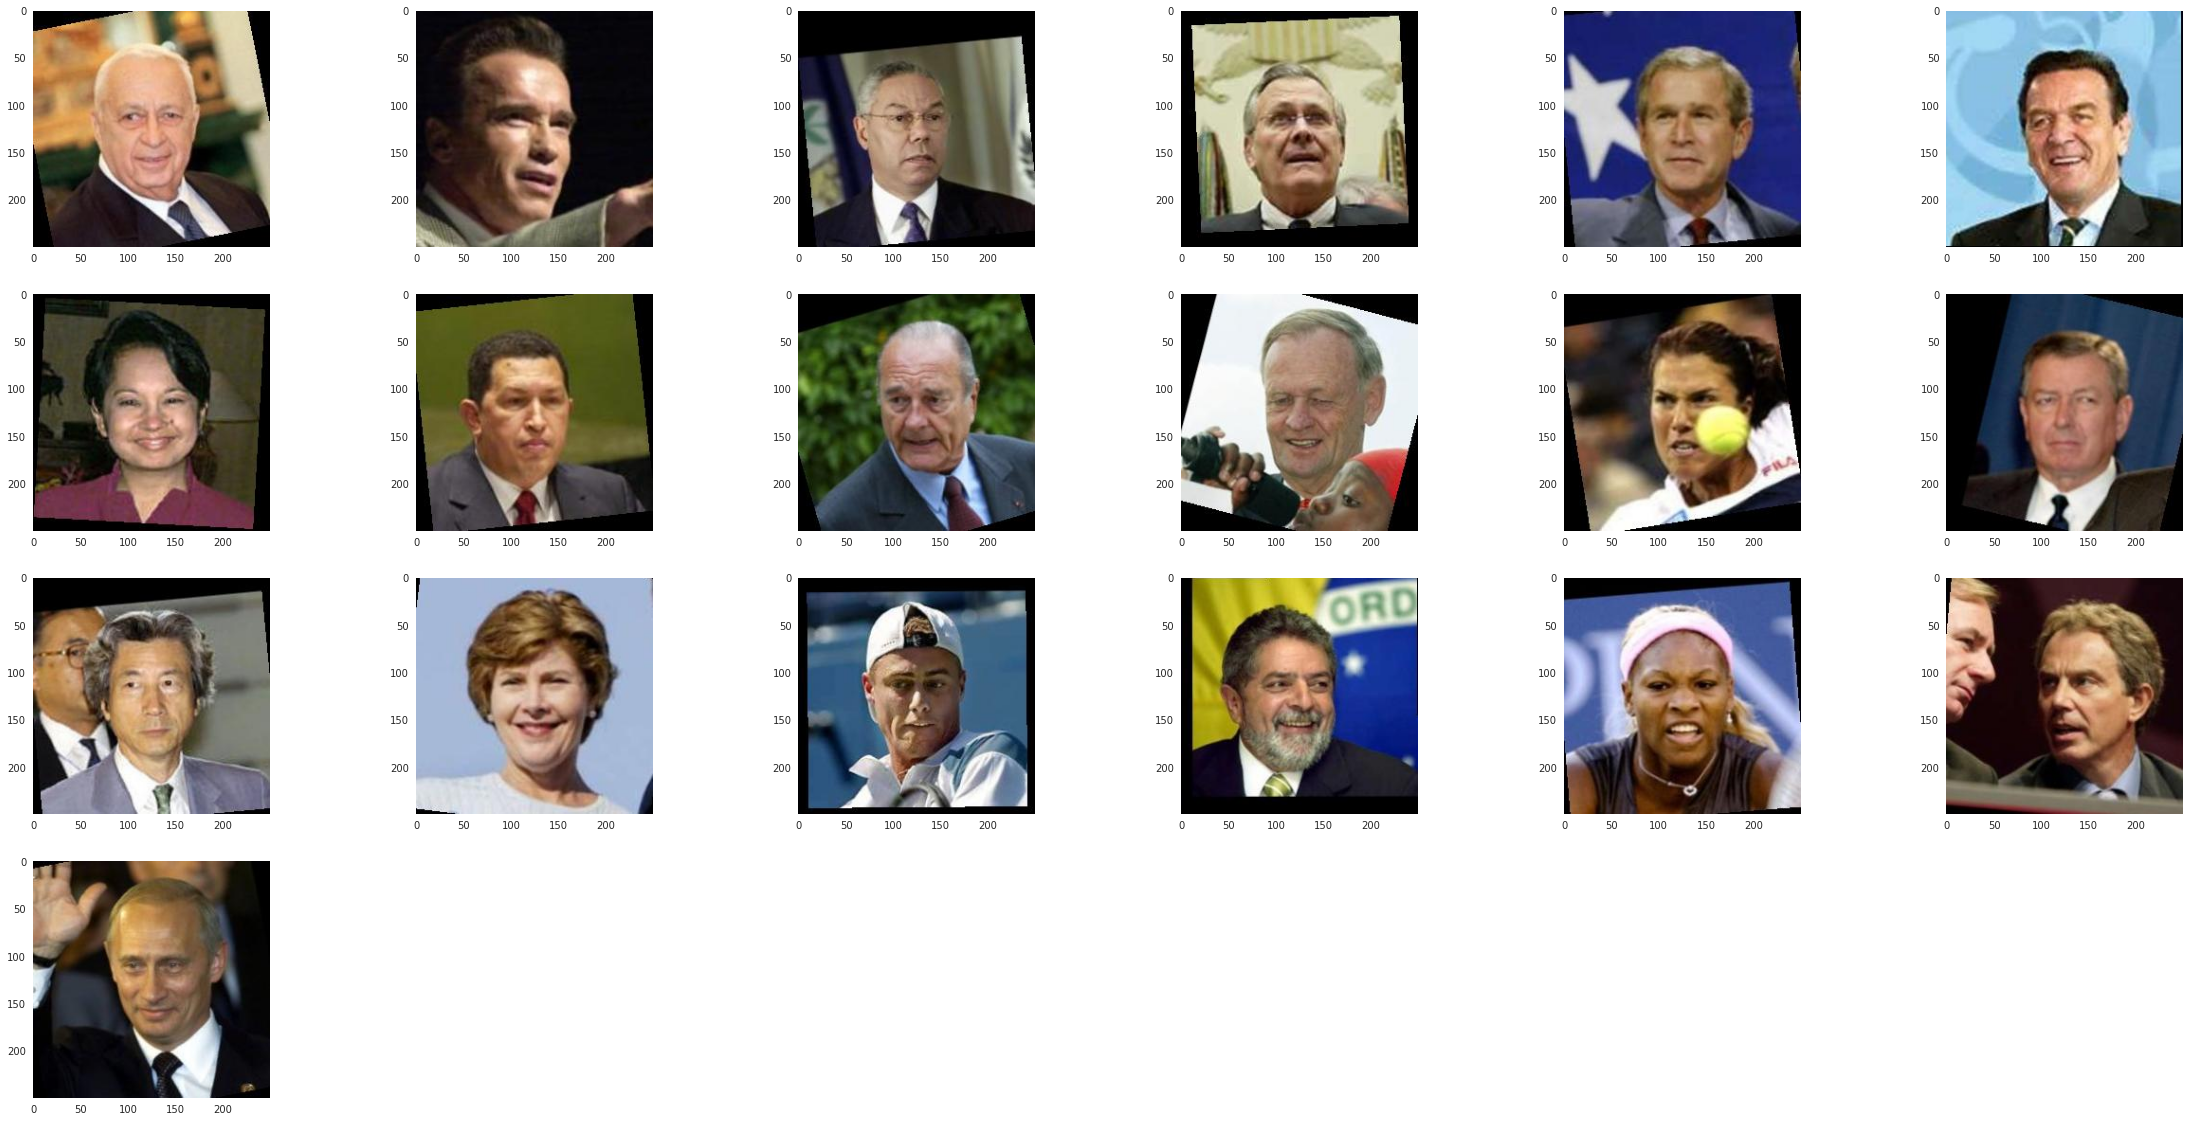

In [ ]:
plt.figure(figsize=(40,20))

plt.subplot(4,6,1)
plt.imshow(img1)
plt.subplot(4,6,2)
plt.imshow(img2)
plt.subplot(4,6,3)
plt.imshow(img3)
plt.subplot(4,6,4)
plt.imshow(img4)
plt.subplot(4,6,5)
plt.imshow(img5)
plt.subplot(4,6,6)
plt.imshow(img6)
plt.subplot(4,6,7)
plt.imshow(img7)
plt.subplot(4,6,8)
plt.imshow(img8)
plt.subplot(4,6,9)
plt.imshow(img9)
plt.subplot(4,6,10)
plt.imshow(img10)
plt.subplot(4,6,11)
plt.imshow(img11)
plt.subplot(4,6,12)
plt.imshow(img12)
plt.subplot(4,6,13)
plt.imshow(img13)
plt.subplot(4,6,14)
plt.imshow(img14)
plt.subplot(4,6,15)
plt.imshow(img15)
plt.subplot(4,6,16)
plt.imshow(img16)
plt.subplot(4,6,17)
plt.imshow(img17)
plt.subplot(4,6,18)
plt.imshow(img18)
plt.subplot(4,6,19)
plt.imshow(img19)

plt.show()

### 2.1 Identificação e segmentação de região de interesse

As imagens que iremos utilizar estão sem nenhum tratamento. Nosso objetivo aqui é ter um recorte somente do rosto de cada uma das pessoas, removendo o fundo e detalhes do vestuário.

Iremos aplicar o classificador de cascatada de Haar e extrair somente as faces de cada imagem, padronizar o tamanho e converter para escala de cinza, que é como os classificadores utilizados trabalham com as imagens. As faces extraídas deverão ser armazenadas na pasta ```treino``` e ```teste```, separando 70% para o treinamento do modelo e 30% para a validação.

In [ ]:
classificador_face = cv2.CascadeClassifier('classificadores/haarcascade_frontalface_default.xml')

def extrator_face_bgr(imagem):
    
    imagem_gray = cv2.cvtColor(imagem,cv2.COLOR_BGR2GRAY)
    faces = classificador_face.detectMultiScale(imagem_gray, 1.2, 5)
    
    if faces is ():
        return None
    
    for (x,y,w,h) in faces:
        roi = imagem[y:y+h, x:x+w]
    
    return roi

A padronização da imagem é necessária pois no treinamento todas elas precisam estar no mesmo tamanho. Iremos aplicar o tamanho ```200x200 pixels``` e também iremos converter a imagem para escala de cinza.

In [ ]:
def padronizar_imagem(imagem):
    imagem_gray = cv2.cvtColor(imagem, cv2.COLOR_BGR2GRAY)
    imagem_gray = cv2.resize(imagem_gray, (200, 200), interpolation=cv2.INTER_LANCZOS4)
    return imagem_gray

Um pequeno ensaio de como as imagens serão transformadas.

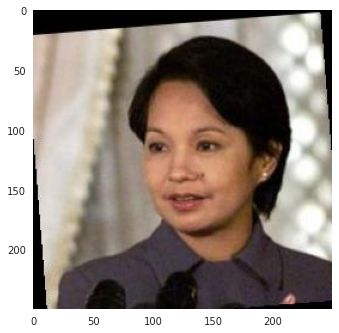

In [ ]:
imagem = cv2.imread("dataset-lfw-filtered/Gloria_Macapagal_Arroyo/Gloria_Macapagal_Arroyo_0002.jpg")
imagem = cv2.cvtColor(imagem, cv2.COLOR_BGR2RGB)
plt.imshow(imagem)

In [ ]:
imagem_gray = cv2.cvtColor(imagem,cv2.COLOR_BGR2GRAY)
faces = classificador_face.detectMultiScale(imagem_gray, 1.2, 5)
faces  

array([[ 72,  71, 109, 109]], dtype=int32)

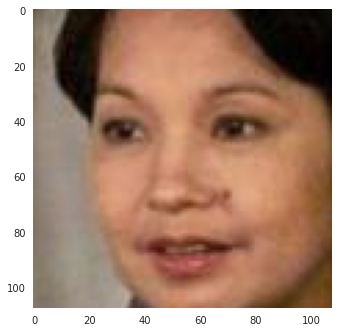

In [ ]:
imagem = cv2.cvtColor(imagem, cv2.COLOR_RGB2BGR)
roi = extrator_face_bgr(imagem)
roi = cv2.cvtColor(roi, cv2.COLOR_RGB2BGR)
plt.imshow(roi)

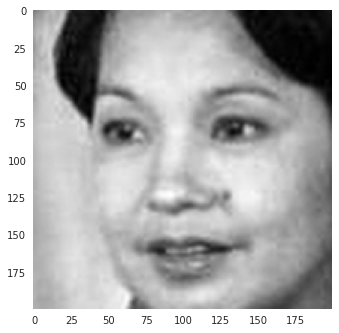

In [ ]:
roi = padronizar_imagem(roi)
plt.imshow(roi, cmap="gray")

### 2.2 Separando dados de treinamento e teste

Cada sujeito (ou face) possui 14 imagens, destas pode existir algumas poses que o classificador não é capaz de identificar, como de lado. Desta forma, vamos trabalhar com imagens de índice até 8 no treino e acima para teste. Na prática, teremos 7 imagens para treino e 3 imagens para teste, alcançando o valor recomendável de validação de 30% do total de treino.

In [ ]:
import glob

for f in tqdm(glob.glob('dataset-lfw-filtered/**/*.jpg', recursive=True)):
  imagem = cv2.imread(f)
  face = extrator_face_bgr(imagem)
  if face is not None:
    roi = cv2.cvtColor(roi, cv2.COLOR_RGB2BGR)
    cv2.imwrite(f.split("/")[0] + "/" + f.split("/")[1] + "/" + "proc_al_" + f.split("/")[2] , face)

100%|██████████| 1867/1867 [00:44<00:00, 42.06it/s]


### 2.2 Preparação para o treinamento dos modelos

Iremos carregar todos as imagens existentes e separar posteriormente uma parte para treinamento (70%) e outra parte para testes de validação (30%).

In [ ]:
lista_sujeitos = []
lista_imagens = []

for f in tqdm(glob.glob('dataset-lfw-filtered/**/proc_*.jpg', recursive=True)):
  lista_sujeitos.append(f.split("/")[1])
  imagem = cv2.imread(f)
  imagem = padronizar_imagem(imagem)
  lista_imagens.append(imagem)

100%|██████████| 1834/1834 [00:01<00:00, 1180.35it/s]


Utilizando o método ```train_test_split``` dividimos os dados em 4 listas, sendo:

* ```X_train```: imagens de treinamento
* ```X_teste```: imagens para teste
* ```y_train```: classes de treinamento
* ```y_test```: classes de teste

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(lista_imagens, lista_sujeitos, test_size=0.3, random_state=42)

In [ ]:
len(X_train),len(X_test), len(y_train), len(y_test)

(1283, 551, 1283, 551)

In [ ]:
X_train[0]

array([[190, 189, 190, ...,  76,  75,  75],
       [190, 190, 190, ...,  75,  75,  74],
       [192, 191, 190, ...,  74,  74,  74],
       ...,
       [132, 132, 133, ...,  37,  38,  38],
       [136, 137, 137, ...,  36,  37,  37],
       [138, 139, 139, ...,  36,  37,  37]], dtype=uint8)

Conversão dos dados em array, necessários para os modelos treinarem de acordo com o padrão da biblioteca que utiliza o formato inteiro de 32 bits (e não 8 bits, como o padrão das imagens).

In [ ]:
X_train = np.asarray(X_train, dtype=np.int32)
X_test = np.asarray(X_test, dtype=np.int32)

In [ ]:
X_train[0]

array([[190, 189, 190, ...,  76,  75,  75],
       [190, 190, 190, ...,  75,  75,  74],
       [192, 191, 190, ...,  74,  74,  74],
       ...,
       [132, 132, 133, ...,  37,  38,  38],
       [136, 137, 137, ...,  36,  37,  37],
       [138, 139, 139, ...,  36,  37,  37]], dtype=int32)

### 2.3 Treinamento e validação do modelo Eingenfaces

Treinamento e testes para validar a precisão do modelo Eingenfaces.
Antes de inciarmos o treinamento, precisamos converter os nomes das celebridades que estão em string para valores de identificação numéricos. Para tanto, vamos utilizar o ```LabelEncoder```.

In [ ]:
sujeitos = list(set(lista_sujeitos))

Neste caso, o label "George_W_Bush", assoicado ao índice 0, deverá ser transformado (_encode_) para um valor numérico.

In [ ]:
y_train[0]

'Colin_Powell'

In [ ]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(sujeitos)
y_train = le.transform(y_train)
y_test = le.transform(y_test)

O valor numérico, para o valor acima de string do label, será:

In [ ]:
y_train[0]

2

In [ ]:
modelo_eingenfaces = cv2.face.EigenFaceRecognizer_create()
modelo_eingenfaces.train(X_train, y_train)

Preparação dos testes de validação, que é a execução do modelo contro as imagens reservadas para teste.

In [ ]:
y_pred_eingenfaces = []

for item in tqdm(X_test):
    y_pred_eingenfaces.append(modelo_eingenfaces.predict(item)[0])
    
acuracia_eingenfaces = accuracy_score(y_test, y_pred_eingenfaces)
acuracia_eingenfaces

100%|██████████| 551/551 [01:14<00:00,  7.37it/s]


0.4029038112522686

### 2.4 Treinamento e validação do modelo Fisherfaces

Treinamento e testes para validar a precisão do modelo Fisherfaces.

In [ ]:
modelo_lda = cv2.face.FisherFaceRecognizer_create()
modelo_lda.train(X_train, y_train)

In [ ]:
y_pred_lda = []

for item in tqdm(X_test):
    y_pred_lda.append(modelo_lda.predict(item)[0])
    
acuracia_lda = accuracy_score(y_test, y_pred_lda)
acuracia_lda

100%|██████████| 551/551 [00:00<00:00, 823.34it/s]


0.662431941923775

### 2.5 Treinamento e validação do modelo LBPH

Treinamento e testes para validar a precisão do modelo LBPH.

In [ ]:
modelo_lbph = cv2.face.LBPHFaceRecognizer_create()
modelo_lbph.train(X_train, y_train)

In [ ]:
y_pred_lbph = []

for item in tqdm(X_test):
    y_pred_lbph.append(modelo_lbph.predict(item)[0])
    
acuracia_lbph = accuracy_score(y_test, y_pred_lbph)
acuracia_lbph

100%|██████████| 551/551 [00:53<00:00, 10.22it/s]


0.7695099818511797

Daddo que as imagens não seguem um padrão de captura, ou seja, estão com poses diferentes uma das outras e levando em consideração que em cada sujeito havia uma pose com baixa luminosidade, pudemos verificar que o classificador Eingenfaces não conseguiu obter precisão de 40%. Enquanto a abordagem por LDA, do classificador Fisherfaces, obteve 66%. Por outro lado, o classificador LBPH foi o mais robusto dentre os 3, alcançando 77% de precisão.

O teste a seguir é para verificarmos que além da identificação do sujeito, temos o valor da distância de similaridade. Com ela podemos também deduzir um limite máximo para determinar se a identificação é indeterminada.

Nos classificadores Eigenfaces e Fisherfaces, valores de distância até 35 e 45 são considerados bons. Ao passo que no classificador LBPH os valores de similaridades utiilizados estão entre os valores entre 40 e 50.

In [ ]:
imagem = cv2.imread("dataset-lfw-filtered/Ariel_Sharon/proc_al_Ariel_Sharon_0029.jpg")
imagem = cv2.cvtColor(imagem, cv2.COLOR_BGR2RGB)
roi = extrator_face_bgr(imagem)
roi_padronizado = padronizar_imagem(roi)

predicao = modelo_lbph.predict(roi_padronizado)
predicao

(0, 58.4910084601391)

In [ ]:
le.inverse_transform([predicao[0]])

array(['Ariel_Sharon'], dtype='<U25')

Text(0.5, 1.0, 'Sujeito: 02, Predição: sujeito Ariel_Sharon distância 58.4910084601391')

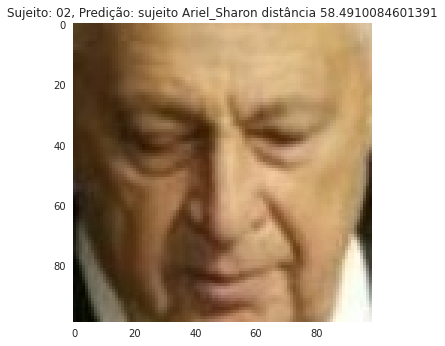

In [ ]:
plt.imshow(imagem)
plt.title("Sujeito: 02, Predição: sujeito " + le.inverse_transform([predicao[0]])[0] + " distância " + str(predicao[1]))

## 3. Deep learning a classificação de imagens

Para criar um modelo de Deep Learning para reconhecimento de imagens utilizando o conjunto de dados [COIL-100](https://www.kaggle.com/datasets/jessicali9530/coil100) da Columbia Object Image Library.

![](https://github.com/michelpf/fiap-ml-visao-computacional/blob/master/aula-5-machine-learning-aplicado/imagens/coil100.jpg?raw=true)

In [ ]:
! rm -rf dataset-coil-100-adapted/

In [ ]:
!git clone https://github.com/michelpf/dataset-coil-100-adapted

Cloning into 'dataset-coil-100-adapted'...
remote: Enumerating objects: 7315, done.
remote: Counting objects: 100% (7315/7315), done.
remote: Compressing objects: 100% (7314/7314), done.
remote: Total 7315 (delta 4), reused 7306 (delta 0), pack-reused 0
Receiving objects: 100% (7315/7315), 124.12 MiB | 16.62 MiB/s, done.
Resolving deltas: 100% (4/4), done.


### 3.1 Identificando as classes

Como um gerador de captchas nem sempre explora todo o alfabeto, vamos identificar exatamente quais as letras são utilizadas para listar todas as possíveis classes deste problema.

In [ ]:
pasta_imagens_treino = "dataset-coil-100-adapted/dataset"
lista_arquivos_classes = [f for f in listdir(pasta_imagens_treino) if isdir(join(pasta_imagens_treino, f))]

lista_classes = list(set(lista_arquivos_classes))
print(lista_classes)
print(len(lista_classes))

['canned-tuna-fish', 'blue-boat-toy', 'cup', 'first-aid-kit', 'sandwich', 'blue-hook', 'truck-toy', 'cigarrette-box-marlboro', 'teapot', 'small-shovel', 'fire-department-truck-toy', 'wood-piece-cillinder-toy', 'alien-toy', 'coke', 'soap-cup', 'japanese-cup', 'floss', 'cheeseburger', 'hook', 'floater', 'women-deodorant-rollon', 'flower-cup', 'juice-extractor', 'correction-fluid-green', 'pain-relief-anacin', 'onion', 'racing-toy', 'cat-toy', 'frog-toy', 'lotion', 'green-boat-toy', 'red-floater', 'bear-toy', 'jar', 'pain-relief-advil', 'sport-car-toy', 'boat-toy', 'fruit-chewing-gum', 'hidradant-cream', 'bulb-plug', 'strawberry', 'vaseline', 'canada-dry-soda', 'correction-fluid-red', 'scotch-tape', 'wood-piece-rectangular-toy', 'antacid-chewing-gum', 'rubber-duck', 'wood-house-toy', 'piggy-bank', 'tiny-vase', 'white-sport-car', 'baby-powder', 'beef-bouillon', 'nuclear-waste', 'green-pepper', 'glue', 'pain-relief-dristan', 'green-cup', 'orange-flower-cup', 'plate', 'chewing-gum', 'pear', '

In [ ]:
train_datagen = ImageDataGenerator(validation_split=0.3, preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    "dataset-coil-100-adapted/dataset",
    batch_size=32,
    class_mode="categorical",
    color_mode='rgb',
    target_size=(128, 128),
    subset='training')

validation_generator = train_datagen.flow_from_directory(
    "dataset-coil-100-adapted/dataset",
    class_mode="categorical",
    color_mode='rgb',
    target_size=(128, 128),
    subset='validation')

Found 5100 images belonging to 100 classes.
Found 2100 images belonging to 100 classes.


### 3.3 Treinamento

Colecionando imagens para treinamento e realizando pequenos ajustes para posterior uso na biblioteca de deep-learning do Keras.

Ao todo temos as seguintes quantidades de exemplos:

Vamos também simplificar a informação de escala de cinza. Utilizaremos a forma normalizada, dividindo todos os valores por 255. Desta forma um pixel 100% branco seria 1, e outro 100% preto seria 0.

Realizando a divisão de treinamento e validação.

### 3.4 Arquitetura

Partimos de um modelo simples que na maioria das vezes resolve problemas de OCR como esse. Como foi citado, identificações mais complexas utilizamos outras aboragens ou evolução de uma arquitetura inicial como esta.

In [ ]:
# Construindo um modelo sequencial
model = Sequential()

# Este componente, se trata de um filtro ou uma camada convulacional. Ela será responsável por 
# colocar uma janela de kernel, navegar pela imagem e extrair a soma dos pixels de cada janela
# o passo para mover a janela, chamado Stride, por padrão é de um pixel
model.add(Conv2D(10, kernel_size=(3, 3), input_shape=(128, 128, 3), activation="relu"))

# A camada de Pooling (ou MaxPooling2D) tem o papel de reduzir a dimensionalidade. Neste caso, a partir 
# da etapa anterior, será dividia em grupos de 2 x 2 pixels e será obtida o maior valor deles
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(10, kernel_size=(3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

# O Dropout é um ruído gerado para evitar overfitting
model.add(Dropout(0.2))

# Esta etapa conhecida como "achatamento" é onde abrimos os dados organizados em tabelas (ou matrizes) 
# para uma única linha
model.add(Flatten())

# A camada densa (ou Dense) conectará cada elemento da camada anterior e passará para a próxima
# camada com as classes existentes
model.add(Dense(128, activation="relu"))

# A camada final, determinará qual classe escolher. Por tal razão ela possui a ativação Softmax, que retorna 
# a probabilidade por classe
model.add(Dense(100, activation="softmax"))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 126, 126, 10)      280       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 63, 63, 10)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 61, 61, 10)        910       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 30, 30, 10)       0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 30, 30, 10)        0         
                                                                 
 flatten_2 (Flatten)         (None, 9000)             

In [ ]:
!pip install visualkeras

     |████████████████████████████████| 992 kB 4.2 MB/s 


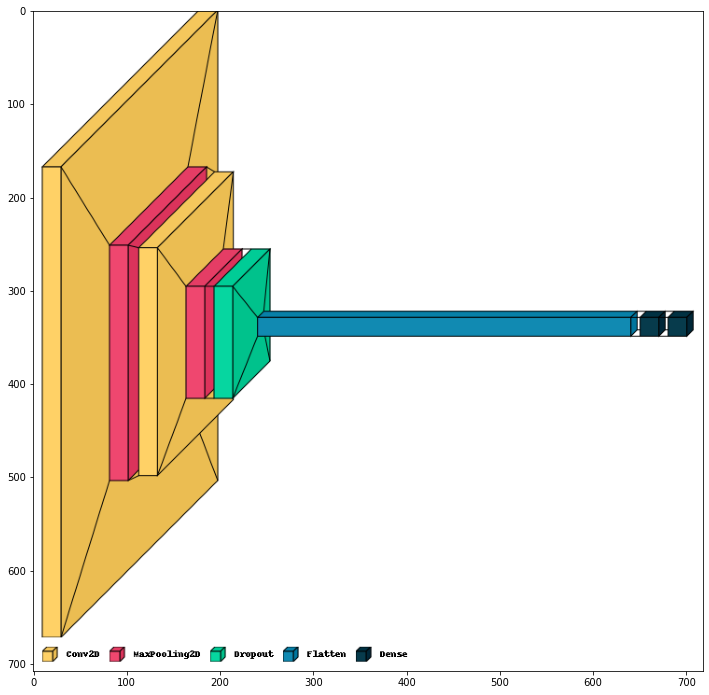

In [ ]:
import visualkeras

visualkeras.layered_view(model, legend=True, to_file="graph.png")

image = cv2.imread("graph.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12,30))
plt.imshow(image)

In [ ]:
!pip install keras-vis

Trecho abaixo ajustado do [Kaggle](https://www.kaggle.com/code/arpitjain007/guide-to-visualize-filters-and-feature-maps-in-cnn/notebook) de Arpit Jain.

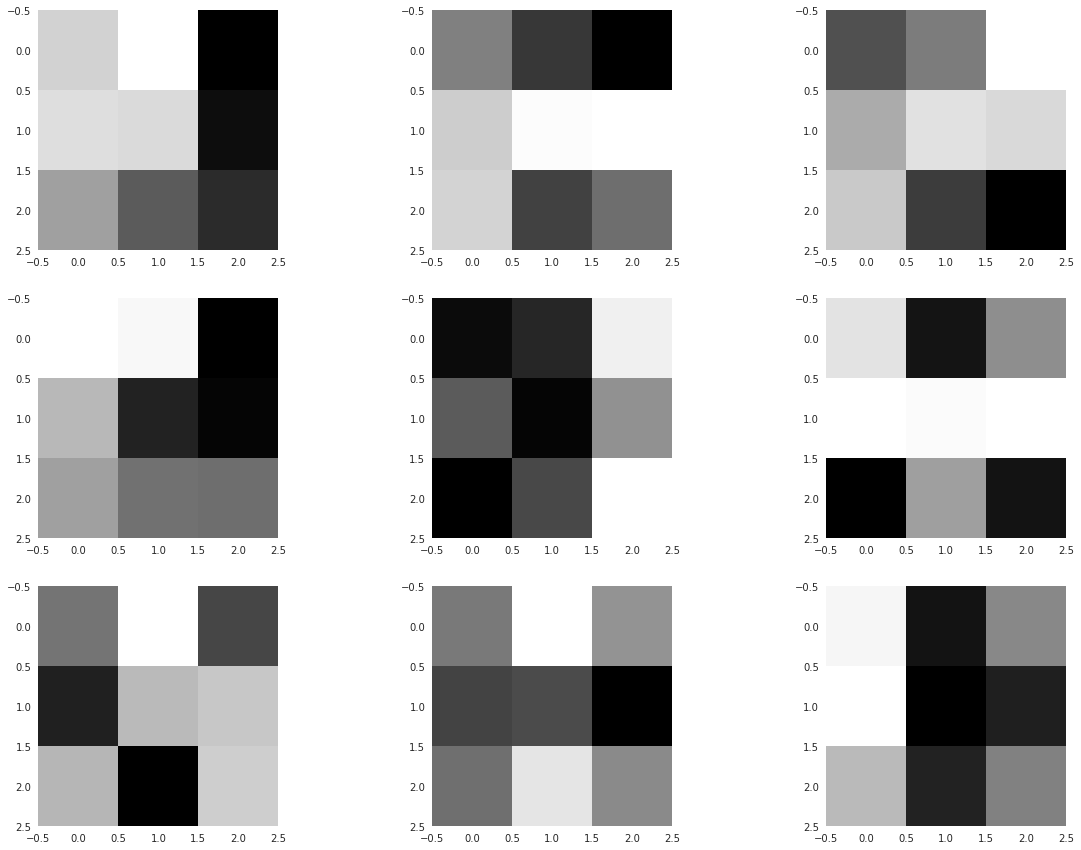

In [ ]:
filters , bias = model.layers[0].get_weights()

f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

n_filters = 3
ix=1

fig = plt.figure(figsize=(20,15))

for i in range(n_filters):
    # get the filters
    f = filters[:,:,:,i]
    for j in range(3):
        # subplot for 6 filters and 3 channels
        plt.subplot(n_filters,3,ix)
        plt.imshow(f[:,:,j] ,cmap='gray')
        ix+=1


#plot the filters 
plt.show()


In [ ]:
model.layers[0]

Para revisão de funções de ativação, em particular [Relu](https://matheusfacure.github.io/2017/07/12/activ-func/).

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_generator, validation_data=validation_generator, epochs=15)

Epoch 1/15
160/160 [==============================] - 21s 70ms/step - loss: 3.3814 - accuracy: 0.5765 - val_loss: 0.7045 - val_accuracy: 0.8233
Epoch 2/15
160/160 [==============================] - 11s 69ms/step - loss: 0.0617 - accuracy: 0.9822 - val_loss: 0.7005 - val_accuracy: 0.8448
Epoch 3/15
160/160 [==============================] - 11s 69ms/step - loss: 0.0233 - accuracy: 0.9945 - val_loss: 0.5464 - val_accuracy: 0.8633
Epoch 4/15
160/160 [==============================] - 11s 68ms/step - loss: 0.0145 - accuracy: 0.9971 - val_loss: 0.7593 - val_accuracy: 0.8514
Epoch 5/15
160/160 [==============================] - 11s 68ms/step - loss: 0.0563 - accuracy: 0.9878 - val_loss: 0.8226 - val_accuracy: 0.8167
Epoch 6/15
160/160 [==============================] - 11s 68ms/step - loss: 0.0369 - accuracy: 0.9890 - val_loss: 0.6606 - val_accuracy: 0.8681
Epoch 7/15
160/160 [==============================] - 11s 70ms/step - loss: 0.0826 - accuracy: 0.9796 - val_loss: 1.0214 - val_accuracy:

Os gráficos a seguir mostram convergência de acurácia para os dados de treinamento e validação.
Note que o valor do erro, diferentemente da acurácia, não é expressada em porcentagem, portanto erro < 1 é um ótimo valor.

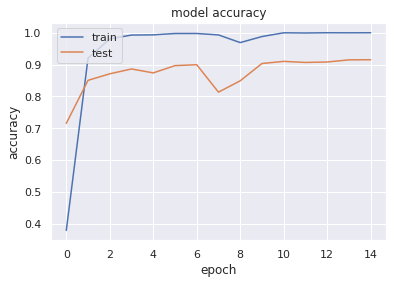

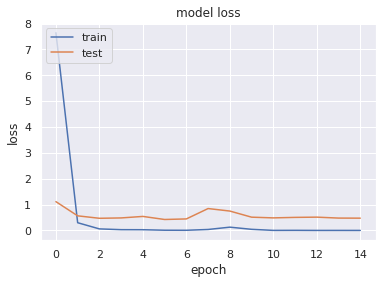

In [ ]:
# Para deixar no formato do Seaborn os gráficos do Pyplot
sns.set()

# Exibindo dados de Acurácia/Precisão
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Exibindo dados de Perda
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Salvando o modelo para uso posterior. Mesmo imagens pequenas como essas levam vários minutos para treinar.

In [ ]:
# Salvando o modelo no formato HDf5
model.save("modelos/model.h5")

# Arquitetura das camadas em JSSON e pesos treinados em HDF5
model.save_weights("pesos/weights.h5")

Uma vez salvo o modelo, nesta etapa é só carregar.

In [ ]:
# carregando o modelo no formato HDf5
model = load_model("modelos/model.h5")  
model.load_weights("pesos/weights.h5")
model.summary()

### 3.5 Testes de validação
Vamos inferir algumas imagens para verificar visualmente como o classificador está se comportando.
Para isso definimos uma função para normalizar uma imagem do captcha, para extrair os ruídos e posteriomente cada uma das suas letras.

Execução da função. Neste caso não fizemos a inversão da imagem pois as letras foram treinadas com o fundo branco.

In [ ]:
imagens_teste_path = ["dataset-coil-100-adapted/dataset/alien-toy/100.png",
                      "dataset-coil-100-adapted/dataset/telephone/10.png",
                      "dataset-coil-100-adapted/dataset/cheeseburger/105.png"
                      ]

lista_imagem = []

for imagem_path in imagens_teste_path:
    imagem = cv2.imread(imagem_path)
    imagem = cv2.cvtColor(imagem, cv2.COLOR_BGR2RGB)
    imagem = cv2.resize(imagem, (128, 128))
    lista_imagem.append(imagem)

lista_imagem_array = np.array(lista_imagem, dtype="float")
lista_imagem_array = preprocess_input(lista_imagem_array)

In [ ]:
pred_probs = model.predict(lista_imagem_array)
y_classes = pred_probs.argmax(axis=-1)

In [ ]:
classes_labels = train_generator.class_indices
key_list = list(classes_labels.keys())
val_list = list(classes_labels.values())

In [ ]:
key_list[val_list[y_classes[0]]]

'alien-toy'

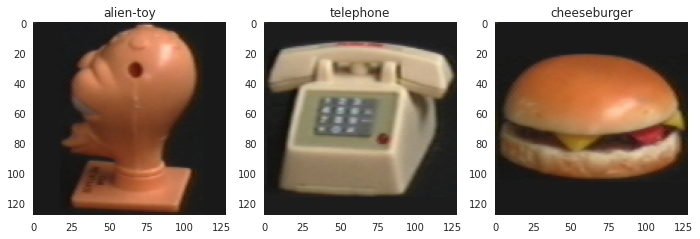

In [ ]:
plt.figure(figsize=(20,10))
plt.axis('off')
plt.grid(False)

for i, imagem in enumerate(lista_imagem):
    plt.subplot(1,5,i+1)
    plt.imshow(imagem)
    plt.title("{}".format(key_list[val_list[y_classes[i]]]))

plt.show()

Agora vamos investigar quais foram as regiões que foram mais atividadas, sendo por sua vez as mais relevantes e com a qual o modelo aprendeu mais. Isso é importante para evitarmos que os nossos modelos aprendam com as características erradas. Um bom exemplo é quando o modelo aprende a classificar uma girafa pelo backgroud árido das savana africanas.

Para a evidenciação destas regiões utilizamos a técnica GradCam, oriundo deste [paper](https://arxiv.org/abs/1610.02391) de Ramprasaath R. Selvaraju, Michael Cogswell, Abhishek Das, Ramakrishna Vedantam, Devi Parikh, Dhruv Batra.

In [ ]:
!pip install tf-explain

     |████████████████████████████████| 43 kB 1.3 MB/s 


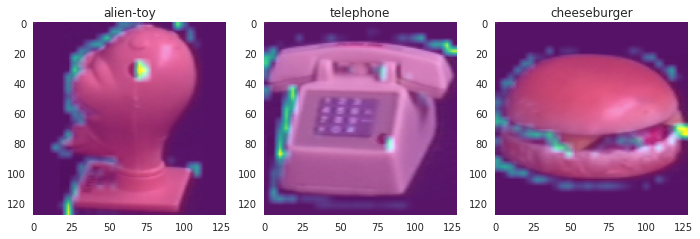

In [ ]:
from tf_explain.core.grad_cam import GradCAM

explainer = GradCAM()

plt.figure(figsize=(20,10))
plt.axis('off')
plt.grid(False)

for i, imagem in enumerate(lista_imagem):
    plt.subplot(1,5,i+1)
    data = ([imagem], None)
    grid = explainer.explain(data, model, class_index=y_classes[i])
    plt.imshow(grid)
    plt.title("{}".format(key_list[val_list[y_classes[i]]]))

plt.show()

## 4. Transfer learning para reconhecimento de imagens

Técnica de transfer learning aplicado a deep learnig para classificação de imagens, utilizando classificados com pesos já treinados disponibilizados no Keras.

Foram utilizadas imagens representado dígitos de 0 a 9 com 500 imagens de cada uma, ao todo 5000 imagens. 

As imagens de treinamento possuem 400 x 400 de resolução com 3 canais (imagens coloridas representadas em BGR ou RGB).

### 4.1 Geradores de imagens

Conjunto de dados utilizado foi [American Sign Language Digit Dataset](https://www.kaggle.com/rayeed045/american-sign-language-digit-dataset), disponível no Kaggle.

Os geradores utilizados foram aplicados para converter o tamanho adequado do modelo utilizado (224 x 224 pixels) como também para criar novos exemplos a partir das imagens no que chamamos de _data augmentation_, por meio de perturbações da imagem baseado em recorte (```shear```), zoom e orientação horizontal (```horizontal_flip```).

Com a técnica de data augmentation ainda é possível crescer o número de imagens de treinamento ao incorporar as distorções citadas.

In [ ]:
!rm -rf dataset-american-sign-language-digit/

In [ ]:
!git clone https://github.com/michelpf/dataset-american-sign-language-digit

Cloning into 'dataset-american-sign-language-digit'...
remote: Enumerating objects: 4619, done.
remote: Counting objects: 100% (4619/4619), done.
remote: Compressing objects: 100% (4617/4617), done.
remote: Total 4619 (delta 1), reused 4613 (delta 0), pack-reused 0
Receiving objects: 100% (4619/4619), 111.48 MiB | 20.55 MiB/s, done.
Resolving deltas: 100% (1/1), done.
Checking out files: 100% (5001/5001), done.


In [ ]:
imagem = cv2.imread("dataset-american-sign-language-digit/dataset/0/Sign 0 (1).jpeg")
imagem.shape

(400, 400, 3)

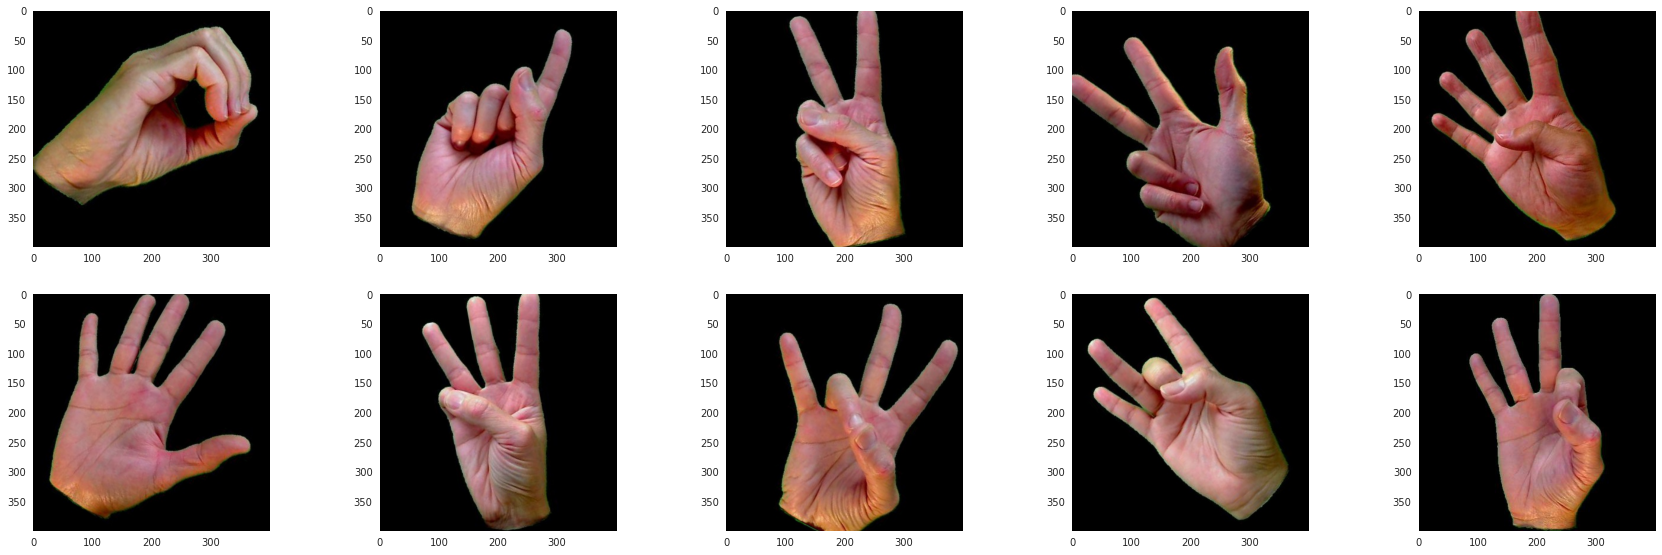

In [ ]:
# Exibição das imagens
img1 = cv2.imread("dataset-american-sign-language-digit/dataset/0/Sign 0 (1).jpeg")
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2 = cv2.imread("dataset-american-sign-language-digit/dataset/1/Sign 1 (2).jpeg")
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
img3 = cv2.imread("dataset-american-sign-language-digit/dataset/2/Sign 2 (3).jpeg")
img3 = cv2.cvtColor(img3, cv2.COLOR_BGR2RGB)
img4 = cv2.imread("dataset-american-sign-language-digit/dataset/3/Sign 3 (4).jpeg")
img4 = cv2.cvtColor(img4, cv2.COLOR_BGR2RGB)
img5 = cv2.imread("dataset-american-sign-language-digit/dataset/4/Sign 4 (5).jpeg")
img5 = cv2.cvtColor(img5, cv2.COLOR_BGR2RGB)
img6 = cv2.imread("dataset-american-sign-language-digit/dataset/5/Sign 5 (6).jpeg")
img6 = cv2.cvtColor(img6, cv2.COLOR_BGR2RGB)
img7 = cv2.imread("dataset-american-sign-language-digit/dataset/6/Sign 6 (8).jpeg")
img7 = cv2.cvtColor(img7, cv2.COLOR_BGR2RGB)
img8 = cv2.imread("dataset-american-sign-language-digit/dataset/7/Sign 7 (9).jpeg")
img8 = cv2.cvtColor(img8, cv2.COLOR_BGR2RGB)
img9 = cv2.imread("dataset-american-sign-language-digit/dataset/8/Sign 8 (10).jpeg")
img9 = cv2.cvtColor(img9, cv2.COLOR_BGR2RGB)
img10 = cv2.imread("dataset-american-sign-language-digit/dataset/9/Sign 9 (11).jpeg")
img10 = cv2.cvtColor(img10, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(30,20))

plt.subplot(4,5,1)
plt.imshow(img1)
plt.subplot(4,5,2)
plt.imshow(img2)
plt.subplot(4,5,3)
plt.imshow(img3)
plt.subplot(4,5,4)
plt.imshow(img4)
plt.subplot(4,5,5)
plt.imshow(img5)
plt.subplot(4,5,6)
plt.imshow(img6)
plt.subplot(4,5,7)
plt.imshow(img7)
plt.subplot(4,5,8)
plt.imshow(img8)
plt.subplot(4,5,9)
plt.imshow(img9)
plt.subplot(4,5,10)
plt.imshow(img10)

plt.show()

In [ ]:
train_datagen = ImageDataGenerator(
    shear_range=10,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.3,
    preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    "dataset-american-sign-language-digit/dataset",
    batch_size=32,
    class_mode="categorical",
    color_mode='rgb',
    target_size=(224,224),
    subset='training')

validation_generator = train_datagen.flow_from_directory(
    "dataset-american-sign-language-digit/dataset",
    class_mode="categorical",
    color_mode='rgb',
    target_size=(224,224),
    subset='validation')

Found 3500 images belonging to 10 classes.
Found 1500 images belonging to 10 classes.


Exibindo as classes identificadas.

In [ ]:
train_generator.class_indices

{'0': 0,
 '1': 1,
 '2': 2,
 '3': 3,
 '4': 4,
 '5': 5,
 '6': 6,
 '7': 7,
 '8': 8,
 '9': 9}

### 4.2. Construindo a rede neural baseado em modelo pré-treinado

O Keras já possui classes especializadas para os seguintes modelos de deep-learning treinados com o conjunto de dados [ImageNet](http://www.image-net.org/):
  
* Xception
* VGG16
* VGG19
* ResNet50
* InceptionV3
* InceptionResNetV2
* MobileNet
* DenseNet
* NASNet
* MobileNetV2

Mais detalhes, veja na [documentação do Keras](https://keras.io/applications/).

_O Keras se encarrega de baixar o modelo automaticamente, não é preciso baixar separadamente._

Note que o parâmetro ```include_top=False``` configura o modelo para não utilizar a camada densa original, pois será substituída pelas novas classes.

In [ ]:
conv_base = VGG19(include_top=False)

for layer in conv_base.layers:
    layer.trainable = False

Removendo a camada densa para que seja adaptada para lidar com apenas 2 classes.

In [ ]:
x = conv_base.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x) 
predictions = layers.Dense(10, activation='softmax')(x)
model = Model(conv_base.input, predictions)

model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0   

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

### 4.3 Treinamento do modelo

In [ ]:
history = model.fit(train_generator, epochs=5, validation_data=validation_generator)

Epoch 1/5
110/110 [==============================] - 86s 767ms/step - loss: 0.9815 - accuracy: 0.6900 - val_loss: 0.6192 - val_accuracy: 0.7733
Epoch 2/5
110/110 [==============================] - 83s 750ms/step - loss: 0.2700 - accuracy: 0.9274 - val_loss: 0.5216 - val_accuracy: 0.7967
Epoch 3/5
110/110 [==============================] - 82s 745ms/step - loss: 0.1636 - accuracy: 0.9594 - val_loss: 0.3331 - val_accuracy: 0.8933
Epoch 4/5
110/110 [==============================] - 82s 743ms/step - loss: 0.1115 - accuracy: 0.9723 - val_loss: 0.3347 - val_accuracy: 0.8807
Epoch 5/5
110/110 [==============================] - 82s 742ms/step - loss: 0.0851 - accuracy: 0.9797 - val_loss: 0.2535 - val_accuracy: 0.9113


Armazenamento do modelo e carregamento do modelo pré-treinado.

In [ ]:
# salvando o modelo no formato HDf5
model.save('modelos/modelo-sign.h5')

# arquitetura das camadas em JSSON e pesos treinados em HDF5
model.save_weights('modelos/weights.h5')
with open('modelos/architecture.json', 'w') as f:
    f.write(model.to_json())

In [ ]:
# carregando o modelo no formato HDf5
model = load_model('modelos/modelo-sign.h5')

# arquitetura das camadas em JSSON e pesos treinados em HDF5
with open('modelos/architecture-sign.json') as f:
    model = model_from_json(f.read())
    
model.load_weights('modelos/weights-sign.h5')

### 4.4 Predição nas imagens de teste

In [ ]:
imagens_teste_path = ["dataset-american-sign-language-digit/dataset/0/Sign 0 (1).jpeg",
                      "dataset-american-sign-language-digit/dataset/1/Sign 1 (1).jpeg",
                      "dataset-american-sign-language-digit/dataset/2/Sign 2 (1).jpeg",
                      "dataset-american-sign-language-digit/dataset/3/Sign 3 (1).jpeg",
                      "dataset-american-sign-language-digit/dataset/4/Sign 4 (1).jpeg",
                      "dataset-american-sign-language-digit/dataset/5/Sign 5 (1).jpeg",
                      "dataset-american-sign-language-digit/dataset/6/Sign 6 (20).jpeg",
                      "dataset-american-sign-language-digit/dataset/7/Sign 7 (1).jpeg",
                      "dataset-american-sign-language-digit/dataset/8/Sign 8 (1).jpeg",
                      "dataset-american-sign-language-digit/dataset/9/Sign 9 (1).jpeg"]

lista_imagem = []

for imagem_path in imagens_teste_path:
    imagem = cv2.imread(imagem_path)
    imagem = cv2.cvtColor(imagem, cv2.COLOR_BGR2RGB)
    imagem = cv2.resize(imagem, (224, 224))
    lista_imagem.append(imagem)

In [ ]:
lista_imagem_array = np.array(lista_imagem, dtype="float")
lista_imagem_array = preprocess_input(lista_imagem_array)

Normalizando as imagens de teste, como neste caso não usamos o gerador do Keras, precisamos ajustar manualmente.

In [ ]:
pred_probs = model.predict(lista_imagem_array)
probs = pred_probs.max(1)
probs

array([0.98880064, 0.96096265, 0.8308939 , 0.9999845 , 0.99835926,
       0.8837343 , 0.997514  , 0.98787814, 0.9831866 , 0.820928  ],
      dtype=float32)

In [ ]:
y_classes = pred_probs.argmax(axis=-1)
y_classes

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

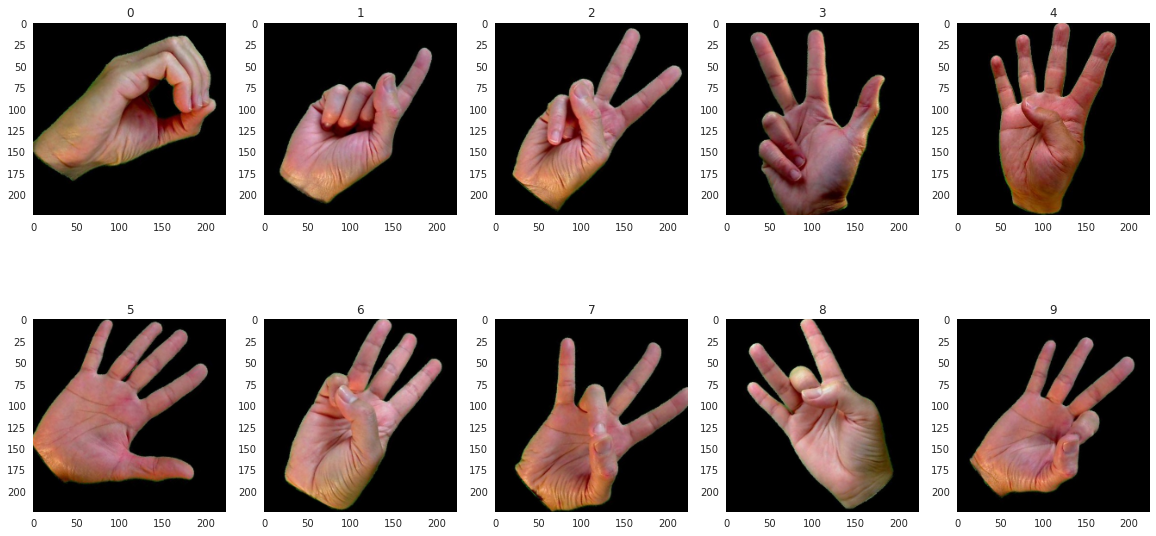

In [ ]:
plt.figure(figsize=(20,10))
plt.axis('off')
plt.grid(False)

for i, imagem in enumerate(lista_imagem):
    plt.subplot(2,5,i+1)
    plt.imshow(imagem)
    plt.title("{}".format(y_classes[i]))

plt.show()

## 5. Classificador de Objetos

É necessário baixar os pesos (modelo de deep-learning) neste link https://pjreddie.com/media/files/yolov3.weights e copiar para  pasta weights. O comando a seguir vai baixar o arquivo de pesos no diretório ```pesos```.

Alguns recursos e códigos foram adaptados deste [repositório](https://github.com/udacity/CVND_Exercises/) do curso de Visão Computacional da Udacity.

In [ ]:
!wget https://pjreddie.com/media/files/yolov3.weights -P pesos/

--2022-03-22 01:48:16--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘pesos/yolov3.weights’

yolov3.weights      100%[===================>] 236.52M  21.1MB/s    in 12s     

2022-03-22 01:48:29 (19.7 MB/s) - ‘pesos/yolov3.weights’ saved [248007048/248007048]



Configurações do modelo.

In [ ]:
%pwd

'/content/fiap-ml-visao-computacional/aula-5-machine-learning-aplicado'

In [ ]:
# Configurações na rede neural YOLOv3
config_file = 'cfg/yolov3.cfg'
modelo_yolo = Darknet(config_file)

# Pesos pré-treinados
weight_file = 'pesos/yolov3.weights'
modelo_yolo.load_weights(weight_file)

# Rótulos de classes
class_names_file = 'data/coco.names'
class_names = load_class_names(class_names_file)

In [ ]:
# Topologia da rede neural da YOLOv3
modelo_yolo.print_network()

layer     filters    size              input                output
    0 conv     32  3 x 3 / 1   608 x 608 x   3   ->   608 x 608 x  32
    1 conv     64  3 x 3 / 2   608 x 608 x  32   ->   304 x 304 x  64
    2 conv     32  1 x 1 / 1   304 x 304 x  64   ->   304 x 304 x  32
    3 conv     64  3 x 3 / 1   304 x 304 x  32   ->   304 x 304 x  64
    4 shortcut 1
    5 conv    128  3 x 3 / 2   304 x 304 x  64   ->   152 x 152 x 128
    6 conv     64  1 x 1 / 1   152 x 152 x 128   ->   152 x 152 x  64
    7 conv    128  3 x 3 / 1   152 x 152 x  64   ->   152 x 152 x 128
    8 shortcut 5
    9 conv     64  1 x 1 / 1   152 x 152 x 128   ->   152 x 152 x  64
   10 conv    128  3 x 3 / 1   152 x 152 x  64   ->   152 x 152 x 128
   11 shortcut 8
   12 conv    256  3 x 3 / 2   152 x 152 x 128   ->    76 x  76 x 256
   13 conv    128  1 x 1 / 1    76 x  76 x 256   ->    76 x  76 x 128
   14 conv    256  3 x 3 / 1    76 x  76 x 128   ->    76 x  76 x 256
   15 shortcut 12
   16 conv    128  1 x 1

In [ ]:
print("Tamanho da imagem de entrada da rede: " + str(modelo_yolo.width) + " x " + str(modelo_yolo.height) + " pixels.")

Tamanho da imagem de entrada da rede: 608 x 608 pixels.


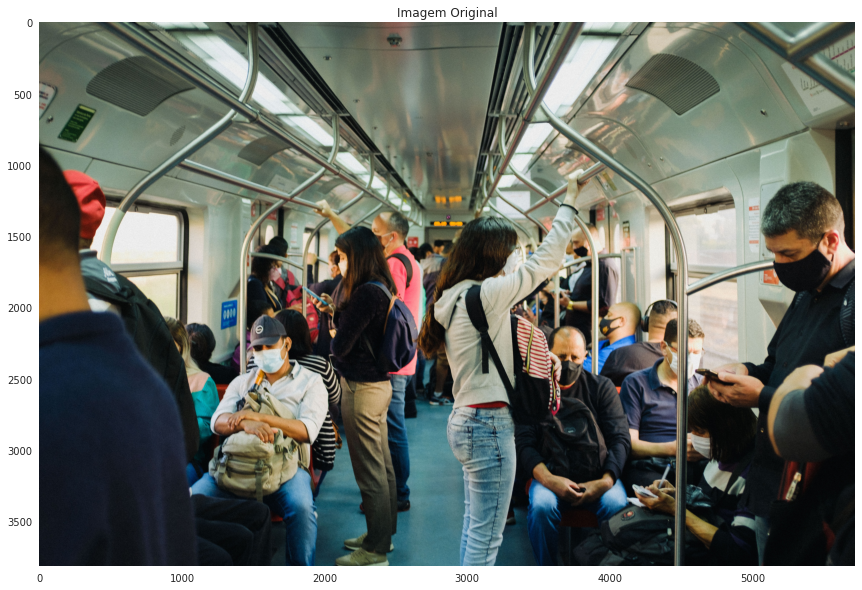

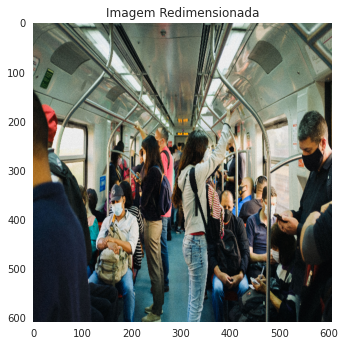

In [ ]:
# Carregando imagem para classificar
imagem = cv2.imread("imagens/dennis-siqueira-TqSVEKceq3Q-unsplash.jpg")

# Convertendo para o espaço de cores RGB
imagem = cv2.cvtColor(imagem, cv2.COLOR_BGR2RGB)

# Redimensionando imagem para ser compatível com a primeira camada da rede neural  
imagem_padronizada = cv2.resize(imagem, (modelo_yolo.width, modelo_yolo.height))

plt.figure(figsize=(30,10))

# Exibição das imagens
plt.title("Imagem Original")
plt.imshow(imagem)
plt.show()

plt.title("Imagem Redimensionada")
plt.imshow(imagem_padronizada)
plt.show()

In [ ]:
# Patamar de NMS (Non-Maximum Supression)
# Ajuste de sensibilidade de imagens com baixa luminosidade
nms_thresh = 0.6

# Patamar do IOU (Intersect of Union), indicador se o retângulo 
# de identificação de imagem foi adequadamente desenhado
iou_thresh = 0.4

In [ ]:
# Definindo tamnaho do gráfico
plt.rcParams['figure.figsize'] = [30, 20]

# Deteteção de objetos na imagem
boxes = detect_objects(modelo_yolo, imagem_padronizada, iou_thresh, nms_thresh)

# Objetos encontrados e nível de confiança
print_objects(boxes, class_names)



It took 3.252 seconds to detect the objects in the image.

Number of Objects Detected: 11 

Objects Found and Confidence Level:

1. person: 1.000000
2. person: 0.999997
3. person: 1.000000
4. person: 1.000000
5. person: 1.000000
6. person: 1.000000
7. person: 0.999995
8. cell phone: 0.999859
9. cell phone: 0.999995
10. person: 1.000000
11. person: 1.000000


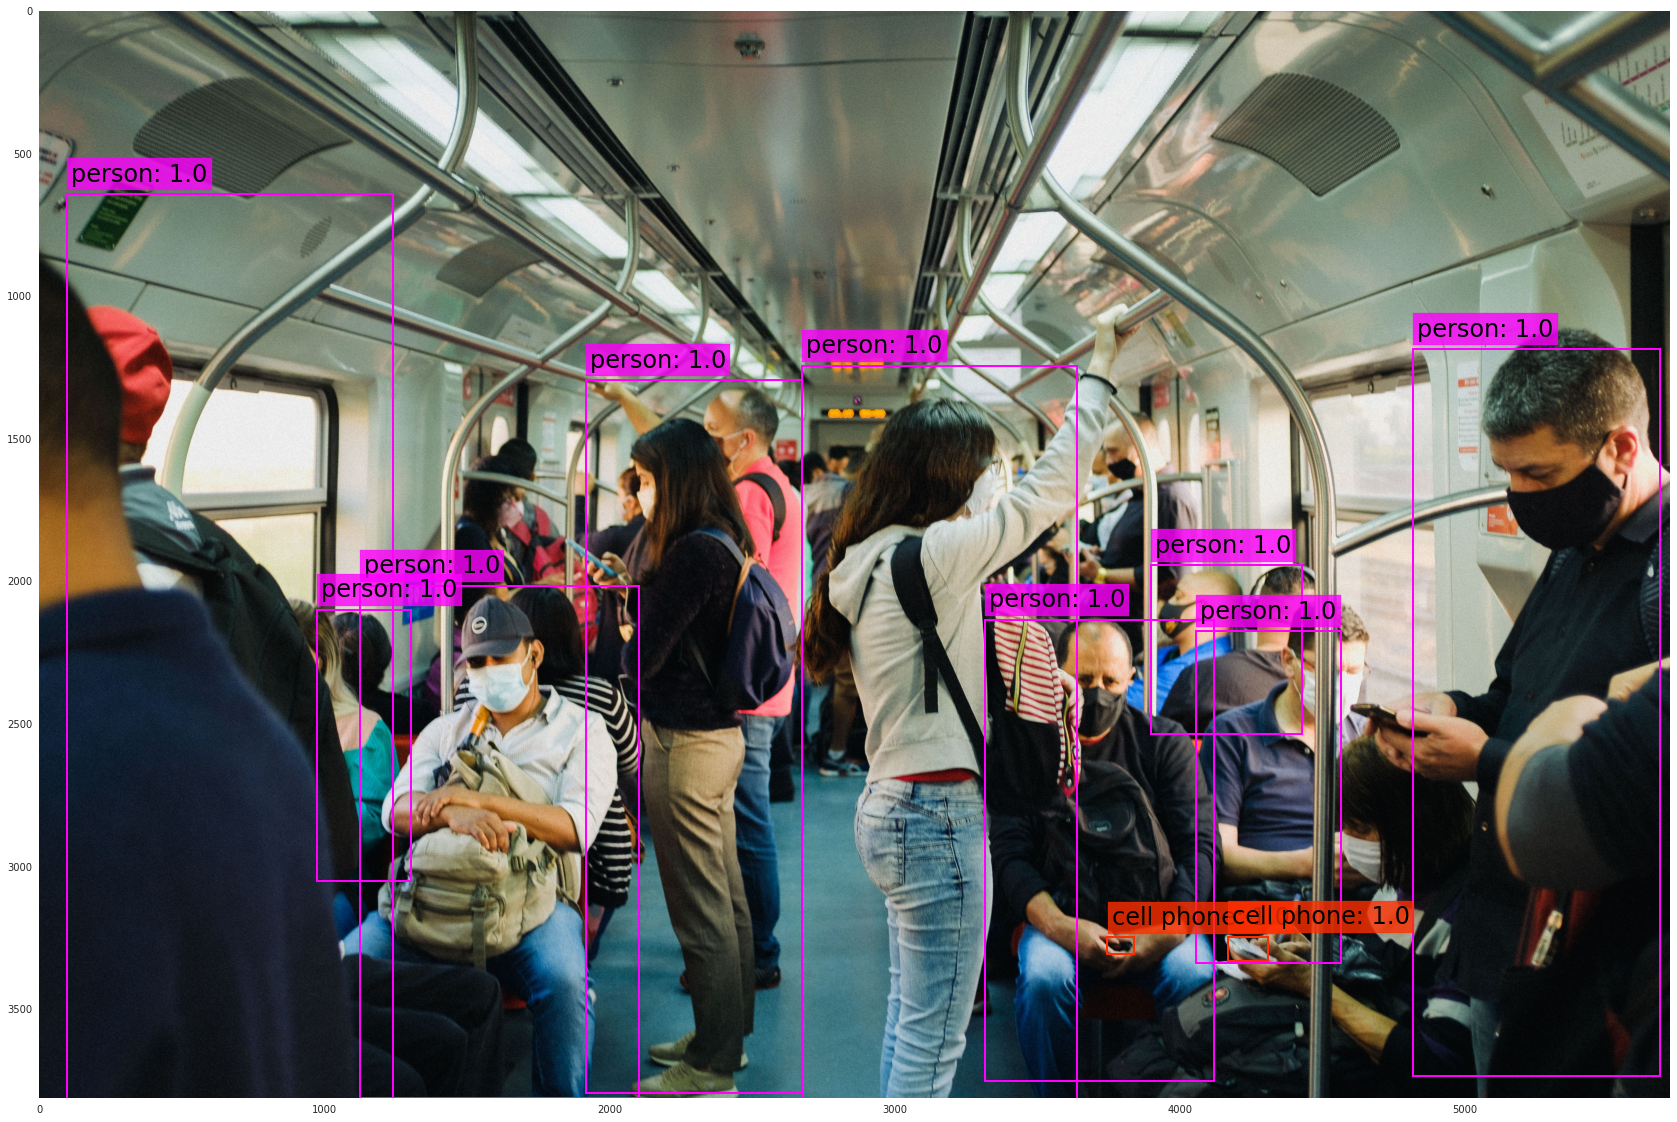

In [ ]:
# Desenho no gráfico com os regângulos e rótulos
plot_boxes(imagem, boxes, class_names, plot_labels = True)